In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download stock data
def get_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df['Avg'] = (df['High'] + df['Low']) / 2  
    return df

# Prepare data
def prepare_data(df, time_steps=100):
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Avg']
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    x_data, y_data = [], []
    for i in range(time_steps, len(scaled_data) - 1):
        x_data.append(scaled_data[i-time_steps:i])
        y_data.append(scaled_data[i+1, 3])  # Ensure correct shape
    
    return np.array(x_data), np.array(y_data), scaler

# Define LSTM model
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.3):
        super(LSTMStockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Shape (batch_size, 1)

# Train model
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    model.to(device)
    best_loss = float('inf')
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        
        scheduler.step(val_loss)
        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")
    
    model.load_state_dict(torch.load("best_model.pth"))
    return model

# Load and process data
ticker = "JPM"
from datetime import datetime 
start_date = "2010-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

df = get_stock_data(ticker, start_date, end_date)

x_data, y_data, scaler = prepare_data(df)
split_idx = int(len(x_data) * 0.7)
x_train, x_test = x_data[:split_idx], x_data[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# Convert to tensors (Fixed Shape Issue)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Ensure shape (batch_size, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Ensure shape (batch_size, 1)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
input_size = x_train.shape[2]
model = LSTMStockPredictor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Train model
model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50)

# Make predictions
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs)
        actuals.extend(targets.numpy())

predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), 5)), np.array(predictions)), axis=1))[:, 5]
actuals = scaler.inverse_transform(np.concatenate((np.zeros((len(actuals), 5)), np.array(actuals).reshape(-1, 1)), axis=1))[:, 5]

# Evaluate model
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print(f"RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

# Predict percentage change
predicted_change = ((predictions[-1] - actuals[-1]) / actuals[-1]) * 100
print("1" if predicted_change > 0 else "0")


[*********************100%***********************]  1 of 1 completed


Epoch [1/50] - Train Loss: 0.010072, Val Loss: 0.119651
Epoch [2/50] - Train Loss: 0.002901, Val Loss: 0.032519
Epoch [3/50] - Train Loss: 0.000163, Val Loss: 0.005897
Epoch [4/50] - Train Loss: 0.000136, Val Loss: 0.003163
Epoch [5/50] - Train Loss: 0.000127, Val Loss: 0.001081
Epoch [6/50] - Train Loss: 0.000121, Val Loss: 0.000998
Epoch [7/50] - Train Loss: 0.000120, Val Loss: 0.000466
Epoch [8/50] - Train Loss: 0.000114, Val Loss: 0.000479
Epoch [9/50] - Train Loss: 0.000117, Val Loss: 0.000461
Epoch [10/50] - Train Loss: 0.000121, Val Loss: 0.000573
Epoch [11/50] - Train Loss: 0.000118, Val Loss: 0.000578
Epoch [12/50] - Train Loss: 0.000108, Val Loss: 0.000609
Epoch [13/50] - Train Loss: 0.000114, Val Loss: 0.000987
Epoch [14/50] - Train Loss: 0.000110, Val Loss: 0.000923
Epoch [15/50] - Train Loss: 0.000103, Val Loss: 0.000939
Epoch [16/50] - Train Loss: 0.000110, Val Loss: 0.001055
Epoch [17/50] - Train Loss: 0.000110, Val Loss: 0.000820
Epoch [18/50] - Train Loss: 0.000105, Va

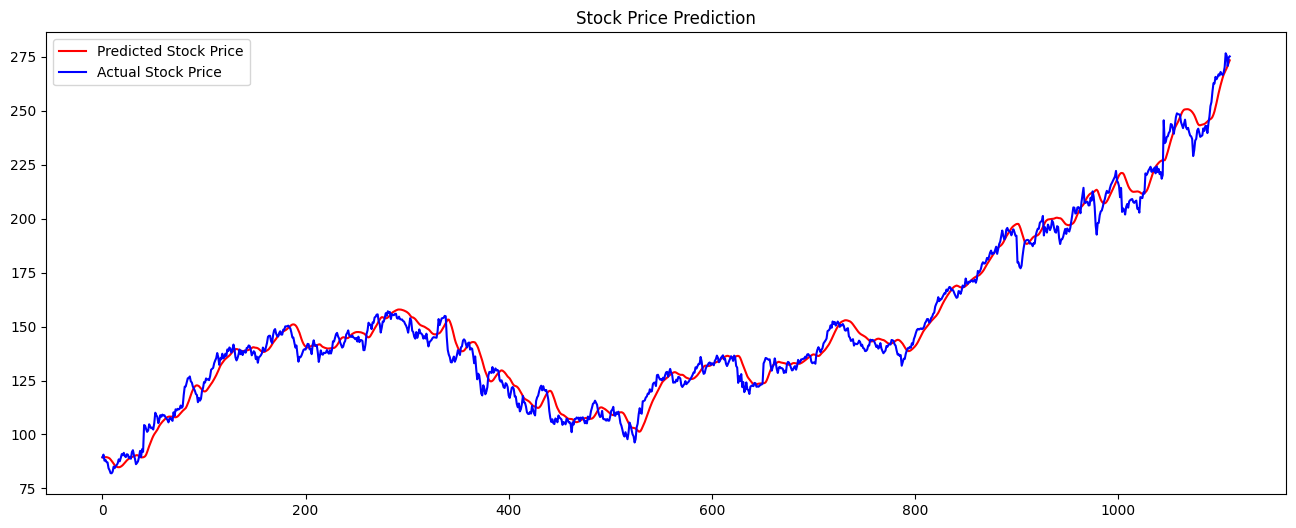

In [52]:
plt.figure(figsize=(16,6))
plt.plot(predictions,label= "Predicted Stock Price" , color = 'red')
plt.plot(actuals,label = "Actual Stock Price" , color = 'blue')
plt.legend()
plt.title("Stock Price Prediction")
plt.show()
         